In [36]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from tqdm import tqdm

### API 연결 및 데이터 파씽

In [37]:
def url_parser(sDate, eDate, row=10):
    ### API 연결 및 데이터 파씽
    key="VFYXI%2F3A5kIk7QVsO1epAlZSb6ZtCO9N5VC%2FMF3pW6oZ7%2BsFrvH1Y9y0UfmVzTnA0k2FasoNM6t6JsY7%2BEwNEw%3D%3D"

    # 기본 url + 사용자 key
    url="http://api.visitkorea.or.kr/openapi/service/rest/KorService/searchFestival?serviceKey=" + key
    url=url+"&MobileOS=ETC&MobileApp=AppTest&arrange=A&listYN=Y"   # 기본 필수 옵션
    url=url+"&numOfRows="+ str(row)   # 한페이지 출력 데이터 개수
    url=url+"&eventStartDate="+str(sDate)  # 조회 시작일
    url=url+"&eventEndDate="+str(eDate)
    #print(url+"\n\n")
    xml_soup=requests.get(url)
    if xml_soup.status_code != 200:
        print("API를 연결하지 못하였습니다.")
        exit()
        
    soup=bs(xml_soup.content, 'html.parser')  # xml_soup.text 변경 가능
    
    return soup


### 파씽한 데이터에서 원하는 데이터 추출 및 DataFrame로 변경

In [38]:
def tour_info(sDate, eDate, soup):
    ### 파씽한 데이터에서 원하는 데이터 추출 및 DataFrame로 변경
    row=soup.find('totalcount').text
    re_soup=url_parser(sDate, eDate, row)
    
    items=re_soup.find_all('item')
    df_list=[]
    
    for item in tqdm(items, desc="진행:"):
        staD=item.find('eventstartdate').text      # 축제 시작일
        endD=item.find('eventenddate').get_text()  # 축제 종료일
        titD=item.find('title').get_text()         # 축제명
        try:
            addD=item.find('addr1').get_text()         # 주소
        except:
            addD="온라인개최"
        try:
            telD=item.find('tel').get_text()           # 전화
        except:
            telD="-"
        try:
            lngD=item.find('mapx').text                # 경도
            latD=item.find('mapy').get_text()          # 위도
        except:
            lngD=0
            latD=0
        
        df_list.append({"시작일":staD, "종료일":endD, "축제명":titD,
                        "주소":addD, "연락처":telD, '위도':latD, '경도':lngD})
        
    df1=pd.DataFrame(df_list)
    
    return df1

### 코드 실행

In [45]:
# if __name__=="__main__":
sDate=input("조회 시작일:(예:20200101):")
eDate=input("조회 종료일:(예:20201231):")

soup=url_parser(sDate, eDate)
df1=tour_info(sDate, eDate, soup)
df1.to_csv('c:/pydata/tour_'+str(sDate)+"_"+str(eDate)+".csv", index=False)

display(df1) #print(df1)

조회 시작일:(예:20200101):20190101
조회 종료일:(예:20201231):20211231


진행:: 100%|███████████████████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 5784.80it/s]


,시작일,종료일,축제명,주소,연락처,위도,경도
0,20210306,20211030,가무악극으로 만나는 토요 상설공연,충청남도 부여군 규암면 백제문로 388,041-832-5765,36.3048428766,126.8997016069
1,20210320,20210630,가산수피아 '봄의 정원',경상북도 칠곡군 가산면 학하들안2길 105,054-971-9861,36.0861545517,128.4850691574
2,20210116,20211231,가족끼리 빙어체험 2021,경기도 양평군 단월면 곱다니길 55-2 수미마을 방문객센터,031-775-5205,37.5145504080,127.6574135888
3,20210301,20210606,가족끼리딸기 캠피닉,경기도 양평군 단월면 곱다니길 55-2,031-775-5205,37.5144948588,127.6573663730
4,20210225,20210228,가족오페라 <마술피리> 2021,대구광역시 북구 호암로 15,053-666-6170,35.8835072863,128.5922570230
...,...,...,...,...,...,...,...
722,20211013,20211017,[문화관광축제] 추억의 충장축제 2021,광주광역시 동구 서남로 1,062-608-2421~4,35.1454973445,126.9231294053
723,20210523,20211130,[문화관광축제] 춘천마임축제,강원도 춘천시 전역,033-242-0585,37.8766011603,127.7178558012
724,20210812,20210821,[문화관광축제] 통영한산대첩축제,경상남도 통영시 통영해안로 328,055-644-5222,34.8438295639,128.4241721001
725,20210611,20210613,[문화관광축제] 한산모시문화제,충청남도 서천군 한산면 충절로 1089,041-950-4256,36.0799251950,126.7987054614


### 축제 데이터 분석
- 1. 2020년~2021년 축제 건수 비교(시작일 기준)
- 2. 축제유형(집합/비대면 축제)
- 3. 지역별 축제 현황

In [46]:
cnt19=0;cnt20=0;cnt21=0

for cntDate in df1['시작일']:
    if cntDate[:4] == "2019":
        cnt19 += 1
    elif cntDate[:4] == "2020":
        cnt20 += 1
    else:
        cnt21 += 1
        
print(cnt19, cnt20, cnt21)
        

8 362 357


In [47]:
df1['시작년']=df1['시작일'].str[:4]
df2=df1.groupby('시작년')['축제명'].count()

C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\bac

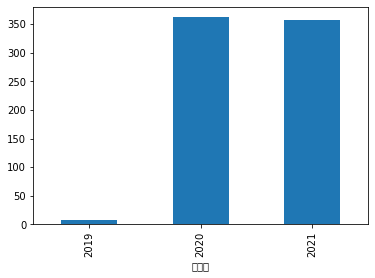

In [48]:
import matplotlib.pyplot as plt

df2.plot.bar()
plt.show()

In [49]:
df1['시작일']=pd.to_datetime(df1['시작일'])
df1['종료일']=pd.to_datetime(df1.종료일)
df1.dtypes

시작일    datetime64[ns]
종료일    datetime64[ns]
축제명            object
주소             object
연락처            object
위도             object
경도             object
시작년            object
dtype: object

<AxesSubplot:ylabel='시작년'>

C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\bac

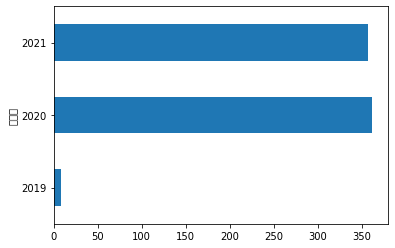

In [64]:
df1['시작년']=df1['시작일'].dt.year
df1['시작월']=df1['시작일'].dt.month

df2=df1.groupby('시작년')['축제명'].count()
df2.plot.barh()

- 축제 시작년/시작월을 기분으로 groupby 
- concat()으로 열 추가하기

In [154]:
df2=df1.groupby(['시작년', '시작월'])['축제명'].count()   # 축제 시작년/시작월 기준 건수 확인
df2=df2.reset_index()   # '시작년', '시작월'을 데이터로 사용하기 위해 index 재설정
#print(df2[df2['시작년']==2021].set_index('시작월'))

df3 = df2[df2['시작년']==2021].set_index('시작월')   # index 시작월로 재설정
df4 = df2[df2['시작년']==2020].set_index('시작월')

df3 = df3.rename(columns = {df3.columns[1]: '2021Y'})       # 각각의 재설정 데이터의 열 이름 변경
df4 = df4.rename(columns = {df4.columns[1]: '2020Y'})

df2 = pd.concat([df3, df4], axis = 1)    # df3를 기준으로 열 추가 => 결과 df2 저장
del df3, df4  # df3, df4 삭제

df2.drop('시작년', axis=1, inplace=True)
print(df2)

     2021Y  2020Y
시작월              
1       43    3.0
2       17    NaN
3       18    NaN
4       54    NaN
5       64    1.0
6       44    2.0
7       38    7.0
8       16   50.0
9       21   78.0
10      34  121.0
11       6   70.0
12       2   30.0


In [155]:
df3=df1.groupby(['시작년', '시작월'])['축제명'].count()
df3=df3.reset_index()
#print(df2[df2['시작년']==2021].set_index('시작월'))

df3=pd.concat([df3[df3['시작년']==2021].set_index('시작월'),
               df3[df3['시작년']==2020].set_index('시작월')], axis=1)
df3.drop('시작년', axis=1, inplace=True)
print(df3)

     축제명    축제명
시작월            
1     43    3.0
2     17    NaN
3     18    NaN
4     54    NaN
5     64    1.0
6     44    2.0
7     38    7.0
8     16   50.0
9     21   78.0
10    34  121.0
11     6   70.0
12     2   30.0


In [158]:
df2=df2.fillna(0)
df3=df3.fillna(0)
print(df2["2020Y"])
print(df3.iloc[:, 1])

시작월
1       3.0
2       0.0
3       0.0
4       0.0
5       1.0
6       2.0
7       7.0
8      50.0
9      78.0
10    121.0
11     70.0
12     30.0
Name: 2020Y, dtype: float64
시작월
1       3.0
2       0.0
3       0.0
4       0.0
5       1.0
6       2.0
7       7.0
8      50.0
9      78.0
10    121.0
11     70.0
12     30.0
Name: 축제명, dtype: float64


C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51089 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Miniconda3\envs\multi\lib\site-packages\matplotlib\bac

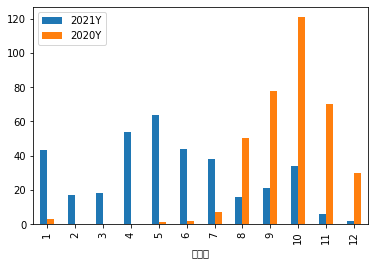

In [159]:
df2.plot.bar()
plt.show()

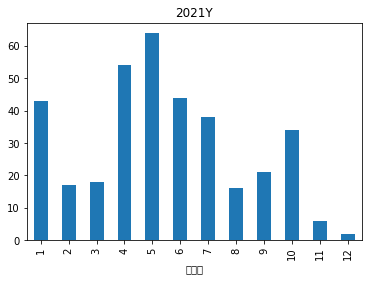

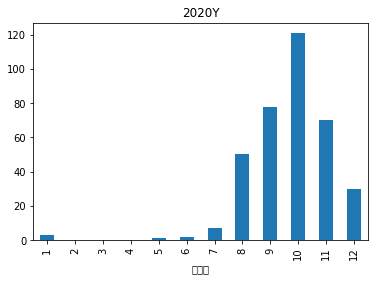

In [166]:
df3.iloc[:, 0].plot.bar()
plt.title('2021Y')
plt.show()
df3.iloc[:, 1].plot.bar()
plt.title('2020Y')
plt.show()

In [170]:
print(df1[(df1['주소']=="온라인개최")&(df1['시작년']==2020)]['주소'].count())
print(df1[(df1['주소']!="온라인개최")&(df1['시작년']==2020)]['주소'].count())

111
251


In [171]:
print(df1[(df1['주소']=="온라인개최")&(df1['시작년']==2021)]['주소'].count())
print(df1[(df1['주소']!="온라인개최")&(df1['시작년']==2021)]['주소'].count())

34
323


In [172]:
pList=[]
pList.append([df1[(df1['주소']=="온라인개최")&(df1['시작년']==2020)]['주소'].count(),
              df1[(df1['주소']!="온라인개최")&(df1['시작년']==2020)]['주소'].count()])
pList.append([df1[(df1['주소']=="온라인개최")&(df1['시작년']==2021)]['주소'].count(),
              df1[(df1['주소']!="온라인개최")&(df1['시작년']==2021)]['주소'].count()])

pList

[[111, 251], [34, 323]]

In [201]:
df2=pd.DataFrame(pList, columns=["온라인", '오프라인'], index=["2020년", "2021년"])
print(df2)

       온라인  오프라인
2020년  111   251
2021년   34   323


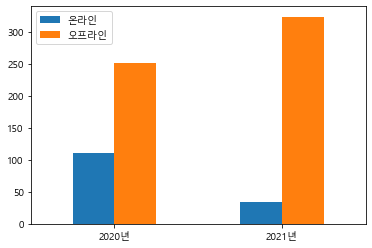

In [193]:
from matplotlib import font_manager

font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()
plt.rc('font', family=font_family)

df2.plot.bar(rot=0)

plt.show()

In [196]:
#!pip install seaborn

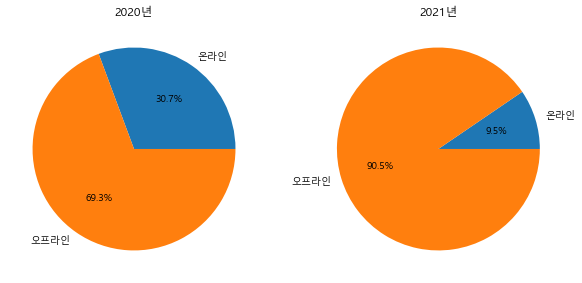

In [215]:
import seaborn as sns
fig=plt.figure(figsize=(10, 5))

#ax1=fig.add_subplot(1, 2, 1)
#ax2=fig.add_subplot(1, 2, 2)

plt.subplot(1,2,1)
x=list(df2.iloc[0])
xlab=df2.columns
plt.pie(x, labels=xlab, autopct="%.1f%%")
plt.title('2020년')

plt.subplot(1,2,2)
x=list(df2.iloc[1])
xlab=df2.columns
plt.pie(x, labels=xlab, autopct="%.1f%%")
plt.title('2021년')

plt.show()

In [207]:
[df2.iloc[0, 0], df2.iloc[0, 1]]

[111, 251]

In [210]:
print(list(df2.loc["2020년"]))
print(list(df2.iloc[0]))

[111, 251]
[111, 251]


#### 지역별 축제 현황[각자 코딩]
- 주소를 " " 기준으로 나누어 첫번째 값 선택
- 해당 값을 이용해서 '지역' 열 생성 및 데이터 추가
- 지역별 축제 현황 분석(현황 테이블화, 시각화-막대그래프, 원그래프, *히트맵 그래프)

### 지도에 축제 위치 출력하기
- folium 모듈

In [218]:
#!pip install folium

In [219]:
import folium

In [222]:
umap=folium.Map(location=[37.503386, 127.049797], zoom_start=15)    # 기본 맵 생성, zoom_start=15 :확대/축소

### 생성된 맵에 Marker(위치기호)를 추가한다.
folium.Marker(location=[37.503386, 127.049797], 
              icon=folium.Icon(color='red'), 
              popup='강의장').add_to(umap)

umap.save('c:/pydata/강의장.html')

In [226]:
df2=df1[(df1['위도']!=0)&(df1['시작년']==2021)]

umap=folium.Map(location=[37.503386, 127.049797], zoom_start=15)

for inx in df2.index:
    folium.Marker(location=[df2.loc[inx,"위도"], df2.loc[inx,'경도']], 
                  icon=folium.Icon(color='red'), 
                  popup=df2.loc[inx,"축제명"]).add_to(umap)

umap.save('c:/pydata/2021년_축제정보.html')

In [235]:
umap=folium.Map(location=[37.503386, 127.049797], zoom_start=15) 

### 지도에 동그라미 표시
folium.CircleMarker([37.503386, 127.049797],
                    color="red",
                    fill_color="#ffffgg",
                    radius = 10, 
                    popup="강의장").add_to(umap)

umap